# Recommendation System for Kampus Merdeka MSIB: Magang (2)
## with Content Based Filtering (CBF)

In [1]:
import   random
import   pickle
import   warnings
warnings.filterwarnings(action='ignore')
import   nltk

In [4]:
# !pip install sastrawi

In [2]:
from pyforest                        import *
from sklearn.metrics                 import precision_score, recall_score, f1_score
from nltk.stem.porter                import PorterStemmer
from sklearn.metrics.pairwise        import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [7]:
df   = pd.read_csv('C:/Users/ASUS/kode/Projek/15. msib_Rekomendasi/data_lowongan.csv')
df

,id_lowongan,durasi,mitra,brand_mitra,logo,nama_lowongan,detail_nama,persyaratan,nama_aktifitas,deskripsi,detail_deskripsi,lokasi,pelaksanaan,sertifikasi
0,60636725-0494-11ef-9e17-0a54edb93563,4,Dinas Lingkungan Hidup dan Kehutanan Daerah Is...,DLHK DIY,https://storage.googleapis.com/kampusmerdeka_k...,Full-stack Developer,Information Technology Systems,Jurusan: Teknologi Informasi atau jurusan lain...,Information Technology Systems,Magang Information Technology Systems di DLHK ...,Pelaksanaan magang di DLHK DIY memiliki bebera...,Kota Yogyakarta,OFFLINE,True
1,1b162247-048d-11ef-bb03-ceeddaa1b367,4,Dinas Lingkungan Hidup dan Kehutanan Daerah Is...,DLHK DIY,https://storage.googleapis.com/kampusmerdeka_k...,Pengelola Arsip,Layanan Pengelolaan Kearsipan,Persyaratan pendaftar program adalah:\n1.\tMah...,Layanan Pengelolaan Kearsipan,Magang Layanan Pengelolaan Kearsipan di DLHK D...,Pelaksanaan magang di DLHK DIY memiliki bebera...,Kota Yogyakarta,OFFLINE,True
2,190c81c5-048a-11ef-9e17-0a54edb93563,4,Dinas Lingkungan Hidup dan Kehutanan Daerah Is...,DLHK DIY,https://storage.googleapis.com/kampusmerdeka_k...,Layanan Publik,Public Relations Services Management-Subbagian...,Persyaratan pendaftar program adalah\n1. Mahas...,Public Relations Services Management-Subbagian...,Magang Pengelolaan Layanan Kehumasan-Subbagian...,Pelaksanaan magang di DLHK DIY memiliki bebera...,Kota Yogyakarta,OFFLINE,True
3,90665e71-0490-11ef-bb7f-6ac06bc5928b,4,Dinas Lingkungan Hidup dan Kehutanan Daerah Is...,DLHK DIY,https://storage.googleapis.com/kampusmerdeka_k...,Staf Manajemen,Licensing And Management Administration- Balai...,Persyaratan pendaftar program adalah\n1. Mahas...,Licensing And Management Administration- Balai...,Magang Licensing and Management Administration...,Pelaksanaan magang di DLHK DIY memiliki bebera...,Kota Yogyakarta,OFFLINE,True
4,f2b8c752-04a0-11ef-8394-36f764739585,4,Dinas Lingkungan Hidup dan Kehutanan Daerah Is...,DLHK DIY,https://storage.googleapis.com/kampusmerdeka_k...,Library Quality Analysis Staff and Integrated ...,Learning Management Improvement Of Public Serv...,Persyaratan pendaftar program adalah\n1. Mahas...,Learning Management Improvement Of Public Serv...,"DLHK DIY telah menginisiasi program ""Optimalis...",Pelaksanaan magang di DLHK DIY memiliki bebera...,Kota Yogyakarta,OFFLINE,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7411,039c521f-4ac2-46a0-b53b-33d487fee509,4,PT SALON KITA INDONESIA,SALONKITA.ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7412,e3e2c034-0365-44b4-badb-c33a22fb33b7,3,PT Modular Kuliner Indonesia,Hangry Indonesia,https://storage.googleapis.com/kampusmerdeka_k...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7413,45bf7d76-36a6-4496-b920-b2cfab9da4e3,4,PT SALON KITA INDONESIA,SALONKITA.ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7414,3049aa1b-9420-4e01-a1dc-36982bd0c054,6,PT Modular Kuliner Indonesia,Hangry Indonesia,https://storage.googleapis.com/kampusmerdeka_k...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df['deskripsi'][0]

'Magang Information Technology Systems di DLHK DIY menawarkan kesempatan untuk terlibat dalam pengembangan dan pemeliharaan sistem teknologi informasi. Ini mencakup pengembangan, pemeliharaan, dukungan pengguna, keamanan informasi, dan pengembangan aplikasi. Peserta magang akan memperoleh pengalaman praktis dalam lingkungan pemerintah dengan bimbingan para profesional IT. Ini merupakan langkah awal yang kuat bagi karir di bidang teknologi informasi, khususnya dalam sektor pelayanan publik.'

### Data Preprocessing
- Cleaning Data missing value
- Seleksi Fitur: Memilih fitur yang relevan dan berguna untuk proses pemodelan.
- Pembersihan Data Teks yang tidak diperlukan pada suatu variabel
- Pembersihan Deskripsi: Mengonversi/merubah kolom 'deskripsi' dan kolom lainnya menjadi list menggunakan metode split.
- Penggabungan Fitur: Menggabungkan semua fitur yang digunakan ke dalam satu fitur utama yang mengandung informasi selain 'nama_produk'.
- Stemming: Melakukan proses stemming untuk menormalkan kata-kata dalam dataset.
- Lowercasing: Mengubah semua teks menjadi huruf kecil untuk konsistensi.
- Count Vectorizer: Mengubah teks menjadi representasi numerik menggunakan Count Vectorizer untuk persiapan pemodelan.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7416 entries, 0 to 7415
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_lowongan       7416 non-null   object
 1   durasi            7416 non-null   int64 
 2   mitra             7416 non-null   object
 3   brand_mitra       7416 non-null   object
 4   logo              7202 non-null   object
 5   nama_lowongan     6218 non-null   object
 6   detail_nama       6218 non-null   object
 7   persyaratan       6218 non-null   object
 8   nama_aktifitas    6218 non-null   object
 9   deskripsi         6218 non-null   object
 10  detail_deskripsi  2302 non-null   object
 11  lokasi            6218 non-null   object
 12  pelaksanaan       6218 non-null   object
 13  sertifikasi       6218 non-null   object
dtypes: int64(1), object(13)
memory usage: 811.3+ KB


In [10]:
df2                   = df.copy()[['nama_lowongan',
                                   'detail_nama',
                                   'persyaratan',
                                   'lokasi']].copy()

df2['nama_lowongan2'] = df2['nama_lowongan']

In [11]:
df2

,nama_lowongan,detail_nama,persyaratan,lokasi,nama_lowongan2
0,Full-stack Developer,Information Technology Systems,Jurusan: Teknologi Informasi atau jurusan lain...,Kota Yogyakarta,Full-stack Developer
1,Pengelola Arsip,Layanan Pengelolaan Kearsipan,Persyaratan pendaftar program adalah:\n1.\tMah...,Kota Yogyakarta,Pengelola Arsip
2,Layanan Publik,Public Relations Services Management-Subbagian...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Layanan Publik
3,Staf Manajemen,Licensing And Management Administration- Balai...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Staf Manajemen
4,Library Quality Analysis Staff and Integrated ...,Learning Management Improvement Of Public Serv...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Library Quality Analysis Staff and Integrated ...
...,...,...,...,...,...
7411,NaN,NaN,NaN,NaN,NaN
7412,NaN,NaN,NaN,NaN,NaN
7413,NaN,NaN,NaN,NaN,NaN
7414,NaN,NaN,NaN,NaN,NaN


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7416 entries, 0 to 7415
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   nama_lowongan   6218 non-null   object
 1   detail_nama     6218 non-null   object
 2   persyaratan     6218 non-null   object
 3   lokasi          6218 non-null   object
 4   nama_lowongan2  6218 non-null   object
dtypes: object(5)
memory usage: 289.8+ KB


### Data Cleaning

In [13]:
df2.isnull().sum()

nama_lowongan     1198
detail_nama       1198
persyaratan       1198
lokasi            1198
nama_lowongan2    1198
dtype: int64

In [14]:
df2_bersih = df2.dropna()

In [15]:
print(df2_bersih.isnull().sum())

nama_lowongan     0
detail_nama       0
persyaratan       0
lokasi            0
nama_lowongan2    0
dtype: int64


In [16]:
df2_bersih.duplicated().sum()

11

In [17]:
df2_bersih = df2_bersih.drop_duplicates()

In [18]:
df2_bersih.head(5)

,nama_lowongan,detail_nama,persyaratan,lokasi,nama_lowongan2
0,Full-stack Developer,Information Technology Systems,Jurusan: Teknologi Informasi atau jurusan lain...,Kota Yogyakarta,Full-stack Developer
1,Pengelola Arsip,Layanan Pengelolaan Kearsipan,Persyaratan pendaftar program adalah:\n1.\tMah...,Kota Yogyakarta,Pengelola Arsip
2,Layanan Publik,Public Relations Services Management-Subbagian...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Layanan Publik
3,Staf Manajemen,Licensing And Management Administration- Balai...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Staf Manajemen
4,Library Quality Analysis Staff and Integrated ...,Learning Management Improvement Of Public Serv...,Persyaratan pendaftar program adalah\n1. Mahas...,Kota Yogyakarta,Library Quality Analysis Staff and Integrated ...


In [19]:
df2_bersih['persyaratan'][1]

'Persyaratan pendaftar program adalah:\n1.\tMahasiswa D4 /S1 Pengelolaan Arsip dan Administrasi Publik atau bidang ilmu yang sesuai\n2.\tMahasiswa minimal semester IV (empat)\n3. Berasal dari Program Studi terakreditasi minimal B atau Baik Sekali\n4.\tMemiliki kemampuan (hardskill dan softskill) sebagai berikut:  Kemampuan Pengolaan Kearsipan, Memiliki  Etos Kerja yang tinggi, Berpikir Kritis dan Mampu Bekerjasama dan Kolaborasi.\n\n'

In [20]:
df2_bersih['persyaratan']      = df2_bersih['persyaratan'].str.replace('\n', '')

In [21]:
df2_bersih['persyaratan']      = df2_bersih['persyaratan'].str.replace('\t', '')

In [22]:
df2_bersih.head(3)

,nama_lowongan,detail_nama,persyaratan,lokasi,nama_lowongan2
0,Full-stack Developer,Information Technology Systems,Jurusan: Teknologi Informasi atau jurusan lain...,Kota Yogyakarta,Full-stack Developer
1,Pengelola Arsip,Layanan Pengelolaan Kearsipan,Persyaratan pendaftar program adalah:1.Mahasis...,Kota Yogyakarta,Pengelola Arsip
2,Layanan Publik,Public Relations Services Management-Subbagian...,Persyaratan pendaftar program adalah1. Mahasis...,Kota Yogyakarta,Layanan Publik


In [23]:
df2_bersih['nama_lowongan2']    = df2_bersih['nama_lowongan2'].astype(str).apply(lambda x: x.split())

In [24]:
df2_bersih['persyaratan']       = df2_bersih['persyaratan'].astype(str).apply(lambda x: x.split())

In [25]:
df2_bersih['detail_nama']       = df2_bersih['detail_nama'].astype(str).apply(lambda x: x.split())

In [26]:
df2_bersih['lokasi']            = df2_bersih['lokasi'].astype(str).apply(lambda x: x.split())

In [27]:
df2_bersih['tags']              = df2_bersih['nama_lowongan2'] + df2_bersih['detail_nama'] + df2_bersih['lokasi'] + df2_bersih['persyaratan']

In [28]:
df2_bersih['tags'][0]

['Full-stack',
 'Developer',
 'Information',
 'Technology',
 'Systems',
 'Kota',
 'Yogyakarta',
 'Jurusan:',
 'Teknologi',
 'Informasi',
 'atau',
 'jurusan',
 'lain',
 'yang',
 'setaraJenjang:',
 'S1Semester:',
 'Minimal',
 'semester',
 '6Kriteria',
 'hard',
 'skills:-',
 'Menguasai',
 'dasar',
 'pemrograman',
 'webKriteria',
 'soft',
 'skills:-Komunikasi-Bekerja',
 'dalam',
 'tim-Memiliki',
 'inisiatif',
 'tinggi']

In [29]:
df_baru = df2_bersih[['nama_lowongan', 'tags']]

In [30]:
df_baru

,nama_lowongan,tags
0,Full-stack Developer,"[Full-stack, Developer, Information, Technolog..."
1,Pengelola Arsip,"[Pengelola, Arsip, Layanan, Pengelolaan, Kears..."
2,Layanan Publik,"[Layanan, Publik, Public, Relations, Services,..."
3,Staf Manajemen,"[Staf, Manajemen, Licensing, And, Management, ..."
4,Library Quality Analysis Staff and Integrated ...,"[Library, Quality, Analysis, Staff, and, Integ..."
...,...,...
7200,General maintenance,"[General, maintenance, Operational, And, Back,..."
7201,Cook & steward,"[Cook, &, steward, Operational, And, Back, Off..."
7202,"Front Desk Agent, Concierge","[Front, Desk, Agent,, Concierge, Operational, ..."
7203,Accounting,"[Accounting, Operational, And, Back, Office, F..."


In [31]:
df_baru['tags'] = df_baru['tags'].apply(lambda x: " ".join(x))

In [32]:
df_baru

,nama_lowongan,tags
0,Full-stack Developer,Full-stack Developer Information Technology Sy...
1,Pengelola Arsip,Pengelola Arsip Layanan Pengelolaan Kearsipan ...
2,Layanan Publik,Layanan Publik Public Relations Services Manag...
3,Staf Manajemen,Staf Manajemen Licensing And Management Admini...
4,Library Quality Analysis Staff and Integrated ...,Library Quality Analysis Staff and Integrated ...
...,...,...
7200,General maintenance,General maintenance Operational And Back Offic...
7201,Cook & steward,Cook & steward Operational And Back Office For...
7202,"Front Desk Agent, Concierge","Front Desk Agent, Concierge Operational And Ba..."
7203,Accounting,Accounting Operational And Back Office For Hot...


In [33]:
df_baru.to_csv('C:/Users/ASUS/kode/Projek/15. msib_Rekomendasi/versi2/data_rekomendasi.csv', index=False)

In [34]:
df_baru['tags'][0]

'Full-stack Developer Information Technology Systems Kota Yogyakarta Jurusan: Teknologi Informasi atau jurusan lain yang setaraJenjang: S1Semester: Minimal semester 6Kriteria hard skills:- Menguasai dasar pemrograman webKriteria soft skills:-Komunikasi-Bekerja dalam tim-Memiliki inisiatif tinggi'

## Stemming
Stemming adalah proses menghilangkan afiks (awalan, akhiran, dan infiks) dari kata untuk menghasilkan bentuk dasarnya, yang disebut "kata dasar" atau "kata dasar". Tujuannya adalah untuk mengkonversi kata-kata yang berbeda tetapi memiliki akar yang sama menjadi bentuk dasar yang seragam. Contohnya, kata-kata "berlari" dan "melarikan" akan diubah menjadi "lari" setelah proses stemming.

### Stemming dengan Sastrawi

Sastrawi adalah sebuah library Python yang dirancang khusus untuk melakukan stemming pada teks dalam bahasa Indonesia. Library ini menggunakan algoritma yang sesuai dengan struktur dan aturan bahasa Indonesia, sehingga mampu mengidentifikasi dan mengubah kata-kata ke bentuk dasarnya dengan baik.

In [35]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [36]:
def stem_tags(tags):
    stemmed_tags = [stemmer.stem(word) for word in tags]
    return ' '.join(stemmed_tags)

In [37]:
df_baru['tags'] = df_baru['tags'].apply(lambda x: stem_tags(x.split()))

In [38]:
df_baru['tags'][0]

'full-stack developer information technology systems kota yogyakarta jurus teknologi informasi atau jurus lain yang setarajenjang s1semester minimal semester 6kriteria hard skills - kuasa dasar pemrograman webkriteria soft skills -komunikasi-bekerja dalam tim-memiliki inisiatif tinggi'

In [39]:
# lowercase dulu untuk mastiin aja
df_baru['tags'] = df_baru['tags'].apply(lambda x: x.lower())

In [40]:
df_baru['tags'][0]

'full-stack developer information technology systems kota yogyakarta jurus teknologi informasi atau jurus lain yang setarajenjang s1semester minimal semester 6kriteria hard skills - kuasa dasar pemrograman webkriteria soft skills -komunikasi-bekerja dalam tim-memiliki inisiatif tinggi'

### Vector Representation dengan Count Vectorizer
mengubah teks menjadi representasi numerik yang dapat dimengerti oleh model mesin. dengan bantuan stopword yang artinya menghapus kata-kata umum yang sering muncul dalam teks dan cenderung tidak memiliki makna khusus dalam proses analisis teks

In [41]:
stop_words_id = ['dan',
                 'di',
                 'dalam',
                 'untuk',
                 'dengan',
                 'yang',
                 'ini',
                 'itu',
                 'apa',
                 'siapa',
                 'kapan',
                 'dimana',
                 'bagaimana',
                 'mengapa']

cv            = CountVectorizer(max_features=5000, stop_words=stop_words_id)

<IPython.core.display.Javascript object>

seperti biasa, mencoba 5000 fitur terlebih dahulu tergantun kapabilitas/

In [42]:
vektor = cv.fit_transform(df_baru['tags']).toarray()

In [43]:
vektor

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [44]:
vektor[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
cv.get_feature_names_out()

array(['00', '000', '002', ..., 'zero', 'zoom', 'zurich'], dtype=object)

## Cosine Similarity / Kemiripan
cosine similarity itu untuk mengukur seberapa mirip dua vektor berada dalam ruang multidimensi array.

Setiap dimensi dalam vektor mewakili kata atau fitur tertentu, dan nilai dalam dimensi tersebut menunjukkan seberapa sering kata tersebut muncul dalam teks. Cosine Similarity mengukur sudut kosinus antara dua vektor. Semakin dekat sudut antara dua vektor, semakin mirip (atau serupa) kedua vektor tersebut. Nilai Cosine Similarity berkisar antara -1 hingga 1, di mana 1 menunjukkan kesamaan sempurna, 0 menunjukkan ketidaksamaan, dan -1 menunjukkan ketidaksamaan sempurna.

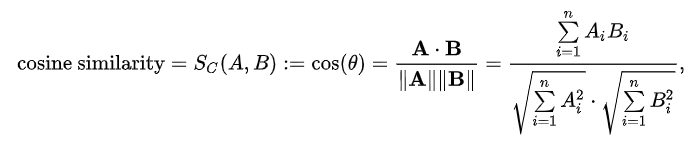

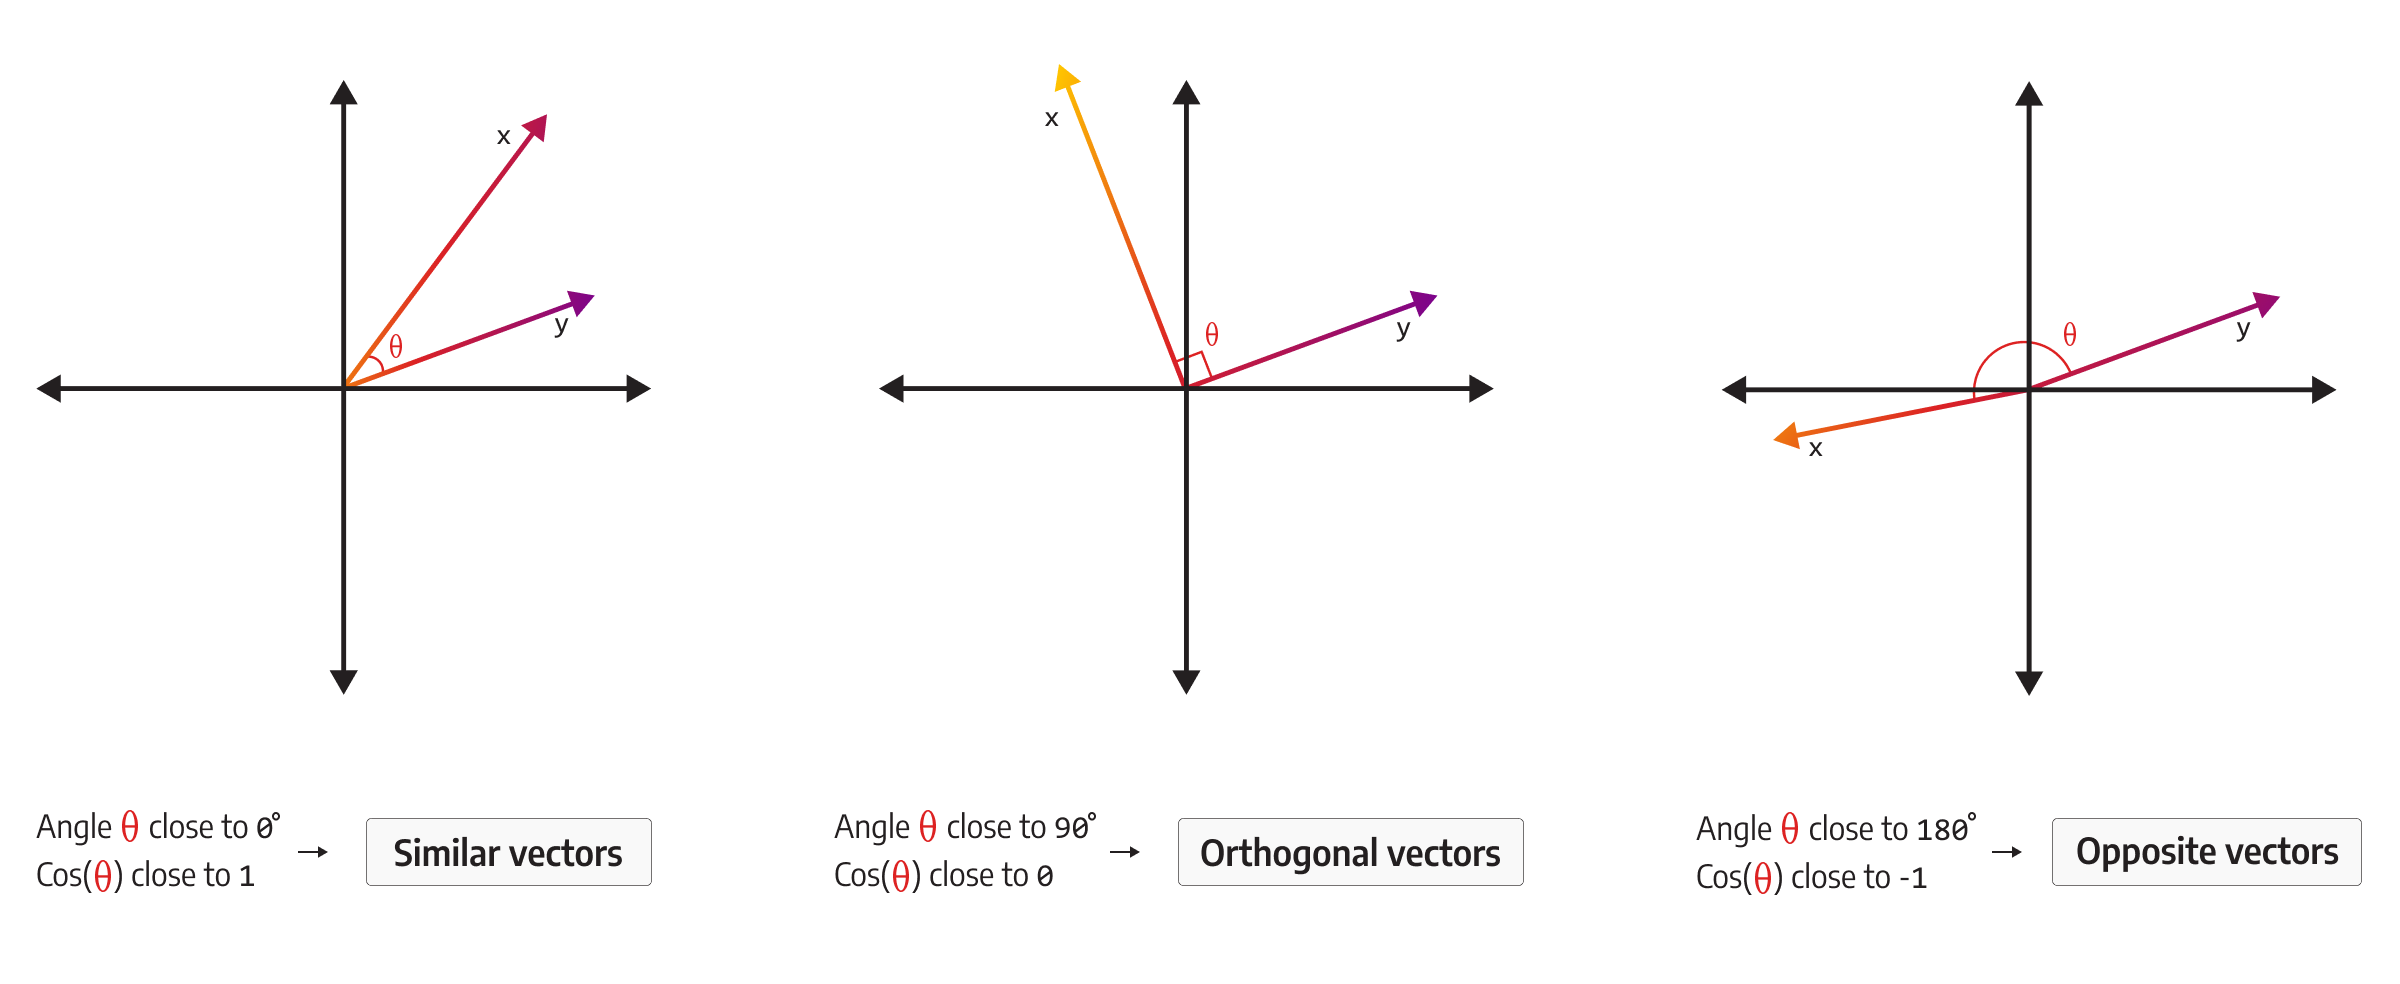

Cosine similarity antara dua vektor diukur dalam 'θ':
- Jika θ = 0°, vektor 'x' dan 'y' saling tumpang tindih, sehingga membuktikan bahwa keduanya serupa.
- Jika θ = 90°, vektor 'x' dan 'y' berbeda.

In [46]:
cosine_similarity(vektor).shape

(6207, 6207)

In [47]:
kesamaan = cosine_similarity(vektor)

In [48]:
kesamaan[0]

array([1.        , 0.14100337, 0.1391882 , ..., 0.13151919, 0.13151919,
       0.08713129])

- enumerate untuk menghasilkan urutan atau no indeks
- reverse = True itu dalam urutan yang tinggi ke terendah
- fungsi lambda itu untuk mengurutkan daftar, jadi ambil elemen kedua (x[1]) dari stiap pasangan sebagai kunci pengurutn kita sampai 5 terats.

In [49]:
# mencari top 5 menu berdasarkan suatu posisi lowongan

sorted(list(enumerate(kesamaan[0])), reverse=True, key=lambda x: x[1])[1:6]

[(2403, 0.6675934204983898),
 (1508, 0.5812381937190965),
 (1506, 0.579147939141922),
 (1505, 0.57186276940104),
 (5742, 0.5314847358217434)]

Hasil kesamaan tersebut cukup baik dikarenakan pada rentang nilai 0-1, khususnya di sekitar 5,3 - 5,5. Mungkin aku bisa ningkatin jumlah top produk yang memiliki kesamaan. Namun berdasarkan try dan error, mungkin kita bisa menampilkan rekomendasi 5 atau top 6 saja.

In [50]:
sorted(list(enumerate(kesamaan[0])), reverse=True, key=lambda x: x[1])[1:7]

[(2403, 0.6675934204983898),
 (1508, 0.5812381937190965),
 (1506, 0.579147939141922),
 (1505, 0.57186276940104),
 (5742, 0.5314847358217434),
 (5739, 0.5135135135135136)]

In [51]:
df_baru['nama_lowongan'] = df_baru['nama_lowongan'] + ' ' + df['mitra']

In [52]:
df_baru['nama_lowongan'] = df_baru['nama_lowongan'].str.replace('\t', '')

In [53]:
df_baru['nama_lowongan'] = df_baru['nama_lowongan'].str.replace('\n', '')

In [54]:
df_baru

,nama_lowongan,tags
0,Full-stack Developer Dinas Lingkungan Hidup da...,full-stack developer information technology sy...
1,Pengelola Arsip Dinas Lingkungan Hidup dan Keh...,kelola arsip layan kelola arsip kota yogyakart...
2,Layanan Publik Dinas Lingkungan Hidup dan Kehu...,layan publik public relations services managem...
3,Staf Manajemen Dinas Lingkungan Hidup dan Kehu...,staf manajemen licensing and management admini...
4,Library Quality Analysis Staff and Integrated ...,library quality analysis staff and integrated ...
...,...,...
7200,General maintenance PT Putra Sumber Wisata Jaya,general maintenance operational and back offic...
7201,Cook & steward PT Putra Sumber Wisata Jaya,cook steward operational and back office for ...
7202,"Front Desk Agent, Concierge PT Putra Sumber Wi...",front desk agent concierge operational and bac...
7203,Accounting PT Putra Sumber Wisata Jaya,accounting operational and back office for hot...


In [55]:
def rekomendasi_magang(lowongan):
    magang_indeks      = df_baru[df_baru['nama_lowongan'] == lowongan].index[0]
    jarak              = kesamaan[magang_indeks] # sebuah list
    daftar_magang      = sorted(list(enumerate(jarak)), reverse=True, key=lambda x: x[1])[1:7]
    rekomendasi_df     = pd.DataFrame(columns=['Nama Lowongan', 'Nilai Kesamaan'])
    
    for i in daftar_magang:
        nama_lowongan  = df_baru.iloc[i[0]].nama_lowongan
        nilai_kesamaan = i[1]
        rekomendasi_df = pd.concat([rekomendasi_df, pd.DataFrame({'Nama Lowongan': [nama_lowongan],
                                                                  'Nilai Kesamaan': [nilai_kesamaan]})],
                                                                   ignore_index=True)
    
    return rekomendasi_df

In [56]:
df_baru['nama_lowongan'][260]

'Program Development: Pendampingan Anak Terdampak TBC Yayasan Bakrie Center'

In [57]:
df_baru['tags'][260]

'program development damping anak dampak tbc provinsi lampung - project cepat eliminasi tbc belum tahun 2030 bas komunitas di provinsi lampung sama inisiatif lampung sehat kota bandar lampung jurus dokter dokter anak sehat masyarakat psikolog psikologi anak awat jenjang d4 s1 semester minimal semester 4  6 kriteria hard skills 1 paham medis tentang tb anak2 manajemen kasus tb anak3 epidemiologi tb4 guna alat medis5 tahu tentang obat tb6 pantau kesehatan7 suluh kesehatan8 manajemen informasi medis9 bijak kesehatan10 mampu pecah masalah11 mampu ambil keputusan12 audit dan evaluasi13 mampu teknologi kesehatan14 kembang program15 pimpin dan manajemen timkriteria soft skills 1 mampu komunikasi2 mampu berempati3 mampu kolaborasi4 mampu konseling5 mampu adaptasi6 mampu manajemen stres7 mampu pemberdayaan8 mampu interaksi dengan anak-anak9 mampu manajemen waktu10 mampu kepemimpinan11 mampu networking12 mampu menginspirasi13 mampu selesai konflikkriteria lain 1 dapat pasti tidak ada kendala dal

In [58]:
rekomendasi_magang('Program Development: Pendampingan Anak Terdampak TBC Yayasan Bakrie Center')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Nama Lowongan,Nilai Kesamaan
0,Program Development: TBC at Workplace Yayasan ...,0.856331
1,Program Development: Divisi Pemberdayaan Ekono...,0.803452
2,Media & Strategic Communications Yayasan Bakri...,0.686308
3,Research & Advocation Yayasan Bakrie Center,0.677035
4,Program Development: Pendampingan Pasien TBC R...,0.669256
5,Program Development: Leadership and Sustainabi...,0.663156


In [98]:
df_baru['nama_lowongan'][0]

'Full-stack Developer Dinas Lingkungan Hidup dan Kehutanan Daerah Istimewa Yogyakarta'

In [99]:
df_baru['tags'][0]

'full-stack developer information technology systems kota yogyakarta jurus teknologi informasi atau jurus lain yang setarajenjang s1semester minimal semester 6kriteria hard skills - kuasa dasar pemrograman webkriteria soft skills -komunikasi-bekerja dalam tim-memiliki inisiatif tinggi'

In [100]:
rekomendasi_magang('Full-stack Developer Dinas Lingkungan Hidup dan Kehutanan Daerah Istimewa Yogyakarta')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Nama Lowongan,Nilai Kesamaan
0,IT Developer PT Mega Manunggal Property Tbk,0.667593
1,Marketing Executive PT Mitra Global Holiday,0.581238
2,Human Resources Staff PT Mitra Global Holiday,0.579148
3,Finance Staff PT Mitra Global Holiday,0.571863
4,Business Developer PT Coca-Cola Distribution I...,0.531485
5,Project Analyst & Support PT Coca-Cola Distrib...,0.513514


In [102]:
df_baru.isnull().sum()

nama_lowongan    0
tags             0
dtype: int64

#### Perbandingan
Hampir seluruhnya rekomendasi lowongan magang yang ditampilkan pada msib kampus merdeka adalah lowongan magang dari mitra itu sendiri. Sehingga agak sulit untuk mencari lowongan magang yang mirip dengan yang kita pilih.

## Kesimpulan 2

Sistem rekomendasi dengan menerapkan Content Based Filtering percobaan ke-2 kali ini memiliki performa yang sedikit lebih baik jika dibandingkan dengan percobaan pertama sebelunnya yang menggunakan data `deskripsi` dan `detail_deskripsi`. Hal ini mungkin dikarenakan aku hanya menggunakan variabel-variabel yang membahas mengenai posisi lowongan magang.

Namun demikian, perlu diingat bahwa kesuksesan suatu sistem rekomendasi tidak hanya ditentukan oleh kemiripan, tetapi juga oleh berbagai faktor lainnya seperti kebutuhan dan preferensi pengguna yang dapat berubah dari waktu ke waktu. Oleh karena itu, perlu adanya upaya terus-menerus dalam pengembangan dan peningkatan sistem rekomendasi ini agar dapat tetap relevan dan efektif dalam menghadapi dinamika pasar dan kebutuhan pelanggan.

#### Solusi yang bisa dilakukan:
- Deep dive understanding terhadap pola dari data `deskripsi` dan `detail_deskripsi`. Lalu memperbaiki data pada fitur `tags`.
- Menggunakan teknik Vectorizer lainnya
- Survey secara langsung untuk mengambil data mengenai posisi-posisi magang yang disukai oleh user lain. Sehingga nantinya bisa menerapkan metode atau teknik **Collaborative Filtering** yang akan lebih cocok dibandingkan CBF.

### Deploy Model

In [103]:
import joblib
import pickle
import numpy as np

pickle.dump(kesamaan, open('C:/Users/ASUS/kode/Projek/15. msib_Rekomendasi/versi2/kesamaan.pkl', 'wb'))
pickle.dump(df_baru, open('C:/Users/ASUS/kode/Projek/15. msib_Rekomendasi/versi2/df_baru.pkl', 'wb'))